# simCLR Intuition


This notebook contains the simplest implementation I could make to understand the simCLR algortihm. The code is based on this [course] (https://lightning.ai/docs/pytorch/latest/notebooks/course_UvA-DL/13-contrastive-learning.html) and the original paper [here](https://arxiv.org/abs/2002.05709).
Unlike the original tutorial, I tried to make the code as simple as possible, so that it is easier to understand the intuition behind the algorithm.


## Dataset

First, let's download the dataset. 
I will use the standard STL-10 dataset, which is a dataset of 96x96 images with 10 classes. The dataset is already available in PyTorch, so we just need to download it.
Furthermore, the data for the unsupervised and supervised sets are nicely separated, so we can use them directly.


## The transformations

First, let's define the transformations that we will use.
The original paper uses a set of transformations that are applied to the images in the unsupervised set.
The transformations are:
- Random crop
- Random horizontal flip
- Color jitter
- Random grayscale
- Rotations
- Gaussian blur
- Sobel filter
- Random erasing

Below I will copy the transformations from the original blog post.

Furthremore, I will also use the same transformation class they use.

/home/tpereira/miniconda3/envs/attention-intuition/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


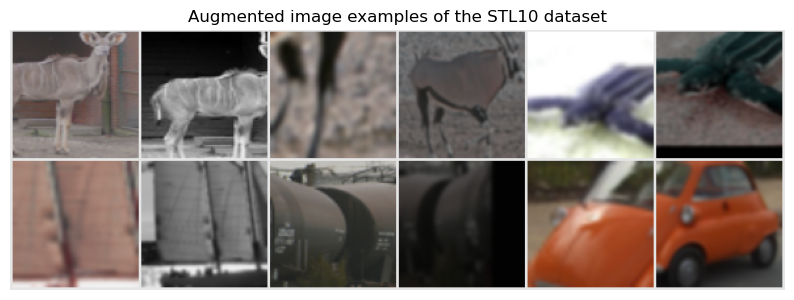

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.datasets import STL10
from torchvision import transforms
import torch.nn.functional as F

EPOCHS = 10
BATCH_SIZE = 64
TAU = 0.07
LR = 1e-1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



contrast_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

class ContrastiveTransformations:
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]
    
unlabeled_data = STL10(
    root="./datasets",
    split="unlabeled",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2),
)
train_data_contrast = STL10(
    root="./datasets",
    split="train",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2),
)


# Visualize some examples
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)


plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the STL10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

## SimCLR implementation

With this dataset we can now put in place the SimCLR algorithm.
The algorithm is composed of two main parts: the encoder $f(.)$ and the projection head $g(.)$.
The encoder is usually a CNN and the projection head is usually a MLP where we apply the contrastive loss as we can see in the image.

![](contrastive.png)

In [2]:
class SimCLR(torch.nn.Module):
    def __init__(self, projection_dim=128, projection_dim_factor=4):
        super().__init__()
        
        # Fixing the encoder to be a ResNet18 so it has less input parameters for the simCLR class
        self.encoder = torchvision.models.resnet18(
            pretrained=False, num_classes=projection_dim*projection_dim_factor
        )

        self.encoder.fc = torch.nn.Sequential(
            self.encoder.fc,
            torch.nn.ReLU(),
            torch.nn.Linear(projection_dim*projection_dim_factor, projection_dim),
        )

        self.encoder.to(device)


    def forward(self, x):
        g = self.encoder(x)  # (batch_size, 512, 3, 3)
        return g
    

## Now let's train the model

In [3]:
# Training the simclr model

train_loader = torch.utils.data.DataLoader(unlabeled_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

model = SimCLR()

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=EPOCHS, eta_min=LR / 50
        )


for epoch in range(EPOCHS):
    for batch_idx, (data, _) in enumerate(train_loader):

        # Stacking everything
        imgs = torch.cat(data, dim=0)
        imgs = imgs.to(device)

        optimizer.zero_grad()
        z = model(imgs)

        # pdist
        cos_sim = F.cosine_similarity(z[:, None, :], z[None, :, :], dim=-1)


        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
                
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / TAU
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = torch.mean(nll)

        nll.backward()
        optimizer.step()

        if batch_idx % 10 == 0:

            # Get ranking position of positive example
            comb_sim = torch.cat(
                [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
                dim=-1,
            )
            sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
            # Logging ranking metrics
            rank_1 = (sim_argsort == 0).float().mean()
            rank_5 = (sim_argsort < 5).float().mean()
            #self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())
            current_lr = optimizer.param_groups[0]["lr"]
            print(f"Epoch [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(train_loader)} " \
                 f"Loss: {nll.item():.4f} " \
                 f"LR: {current_lr} "   \
                 f"Rank@1: {rank_1} Rank@5: {rank_5}"
            )
    
    lr_scheduler.step()

/home/tpereira/miniconda3/envs/attention-intuition/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tpereira/miniconda3/envs/attention-intuition/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [0/10] Batch 0/1563 Loss: 4.8956 LR: 0.1 Rank@1: 0.015625 Rank@5: 0.0546875
Epoch [0/10] Batch 10/1563 Loss: 4.7726 LR: 0.1 Rank@1: 0.015625 Rank@5: 0.0625
Epoch [0/10] Batch 20/1563 Loss: 4.5703 LR: 0.1 Rank@1: 0.0234375 Rank@5: 0.15625
Epoch [0/10] Batch 30/1563 Loss: 4.6555 LR: 0.1 Rank@1: 0.0546875 Rank@5: 0.1328125
Epoch [0/10] Batch 40/1563 Loss: 4.6945 LR: 0.1 Rank@1: 0.0234375 Rank@5: 0.09375
Epoch [0/10] Batch 50/1563 Loss: 4.6696 LR: 0.1 Rank@1: 0.0234375 Rank@5: 0.078125
Epoch [0/10] Batch 60/1563 Loss: 4.6540 LR: 0.1 Rank@1: 0.03125 Rank@5: 0.078125
Epoch [0/10] Batch 70/1563 Loss: 4.7152 LR: 0.1 Rank@1: 0.015625 Rank@5: 0.1015625
Epoch [0/10] Batch 80/1563 Loss: 4.6216 LR: 0.1 Rank@1: 0.046875 Rank@5: 0.1328125
Epoch [0/10] Batch 90/1563 Loss: 4.7013 LR: 0.1 Rank@1: 0.03125 Rank@5: 0.0703125
Epoch [0/10] Batch 100/1563 Loss: 4.7467 LR: 0.1 Rank@1: 0.015625 Rank@5: 0.03125
Epoch [0/10] Batch 110/1563 Loss: 4.7194 LR: 0.1 Rank@1: 0.046875 Rank@5: 0.0625
Epoch [0/10] Ba

## Now we can use the base encoder to train a downstream task

In [4]:
print(model.encoder)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  